# [E4] 4th project NAVER Movie Review
1. 네이버리뷰
 - 데이터 전처리
 - 데이터중복확인 및 제거
 - 토큰화
 - 정수 인코딩
 - 빈샘플 제거
 - 패딩
 - LSTM (RNN)
 - LSTM (RNN)
 - CNN
 - MaxPooling
2. gensim Word2Vec 불러오기 
3. Word2Vec 학습하기
4. 결론


# 1. 네이버 리뷰

In [21]:
# 패키지를 불러오기
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import os
from gensim.models.keyedvectors import Word2VecKeyedVectors
from tensorflow.keras.initializers import Constant
from konlpy.tag import Mecab

from gensim.models import KeyedVectors
import os
import gensim

In [22]:
# 데이터를 읽어봅시다. 네이버리뷰 미리 다운받은 데이터
train_data = pd.read_table('~/aiffel/sentiment_classification/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/ratings_test.txt')

print('테스트용 리뷰 개수 :',len(test_data)) # 테스트용 리뷰 개수 출력
print('훈련용 리뷰 개수 :',len(train_data)) # 훈련용 리뷰 개수 출력

# 데이터를 몇개만 출력해보자
train_data.head() # 훈련용 데이터 헤드 

테스트용 리뷰 개수 : 50000
훈련용 리뷰 개수 : 150000


,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [23]:
# 훈련용 데이터 document와 label 개수를 호가인해보자.
train_data['document'].nunique(), train_data['label'].nunique()

(146182, 2)

In [24]:
# 데이터 중복 확인
#훈련용 데이터 150000 개 중에 146182를 뺀 3818개가 document에서 중복
#훈련용 데이터 labeL 0과 1만 가지므로 2가 출력됨. 
train_data.drop_duplicates(subset=['document'], inplace=True) 
print('총 샘플의 수 :',len(train_data))

총 샘플의 수 : 146183


In [25]:
# 데이터 중복 제거
#document 열에서 중복인 내용 제거 후 총 샘플 수 확인
# null값 확인
print(train_data.isnull().values.any())
print(train_data.isnull().sum())
train_data.loc[train_data.document.isnull()]
train_data = train_data.dropna(how = 'any') # Null 값이 존재하는 행 제거
print(train_data.isnull().values.any()) # Null 값이 존재하는지 확인
print(len(train_data))

train_data['document'].replace('', np.nan, inplace=True)
print(train_data.isnull().sum())
train_data = train_data.dropna(how = 'any')
print(len(train_data))

True
id          0
document    1
label       0
dtype: int64
False
146182
id          0
document    0
label       0
dtype: int64
146182


In [26]:
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
# 한글과 공백을 제외하고 모두 제거
train_data[:5]

/home/aiffel/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  """Entry point for launching an IPython kernel.


,id,document,label
0,9976970,아 더빙 진짜 짜증나네요 목소리,0
1,3819312,흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 솔직히 재미는 없다평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화스파이더맨에서 늙어보이기만 했던 커스틴 던...,1


In [27]:
# 테스트 데이터도 동일하게 제거를 하자
test_data.drop_duplicates(subset = ['document'], inplace=True) # document 열에서 중복인 내용이 있다면 중복 제거
test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
test_data['document'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
test_data = test_data.dropna(how='any') # Null 값 제거
print('전처리 후 테스트용 샘플의 개수 :',len(test_data))

전처리 후 테스트용 샘플의 개수 : 48995


/home/aiffel/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  This is separate from the ipykernel package so we can avoid doing imports until


In [28]:

tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 

    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)

    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}

    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]

    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))

    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index

X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)
print("훈련 샘플 개수: {}, 테스트 개수: {}".format(len(X_train), len(X_test)))

훈련 샘플 개수: 143682, 테스트 개수: 48417


# 빈샘플 제거

In [29]:
drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]

# 빈 샘플들을 제거
X_train = np.delete(X_train, drop_train, axis=0)
y_train = np.delete(y_train, drop_train, axis=0)

print(len(X_train))
print(len(y_train))

words = np.concatenate(X_train).tolist()
counter = Counter(words)
counter = counter.most_common(10000-4)    
vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
word_to_index = {word:index for index, word in enumerate(vocab)} # enumerate 열거하다
    
def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]

X_train = list(map(wordlist_to_indexlist, X_train))
X_test = list(map(wordlist_to_indexlist, X_test))

index_to_word = {index:word for word, index in word_to_index.items()}

143652
143652


/home/aiffel/anaconda3/envs/aiffel/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


# 패딩

리뷰의 최대 길이 : 83
리뷰의 평균 길이 : 13.937515662851892


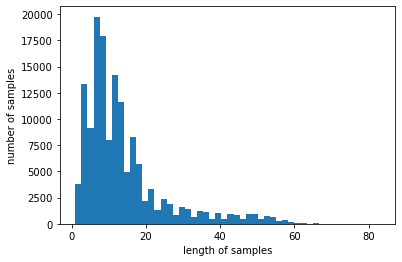

전체 샘플 중 길이가 30 이하인 샘플의 비율: 90.57235541447388


In [30]:
print('리뷰의 최대 길이 :',max(len(l) for l in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))*100))

max_len = 30
below_threshold_len(max_len, X_train)

X_train = pad_sequences(X_train, padding='pre', maxlen = max_len)
X_test = pad_sequences(X_test, padding='pre', maxlen = max_len)

# LSTM 분류하기

In [31]:
vocab_size = 10000  # 어휘 사전의 크기입니다(10개의 단어), 위에서 사이즈가 정해져 있으므로 생략
word_vector_dim = 100  # 단어 하나를 표현하는 임베딩 벡터의 차원수입니다. 

model_LSTM = Sequential()
model_LSTM.add(Embedding(vocab_size, word_vector_dim))
model_LSTM.add(LSTM(128))
model_LSTM.add(Dense(1, activation='sigmoid'))
model_LSTM.summary()

epochs=1

model_LSTM.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
# validation 0.2 (20%설정)
history = model_LSTM.fit(X_train, y_train, epochs=epochs, batch_size=60, validation_split=0.2)

results = model_LSTM.evaluate(X_test,  y_test, verbose=2)
print(results)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 100)         1000000   
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 1,117,377
Trainable params: 1,117,377
Non-trainable params: 0
_________________________________________________________________
1916/1916 [==============================] - 12s 6ms/step - loss: 0.3913 - accuracy: 0.8204 - val_loss: 0.3544 - val_accuracy: 0.8431
1514/1514 - 2s - loss: 0.3573 - accuracy: 0.8415
[0.35729581117630005, 0.8415432572364807]


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


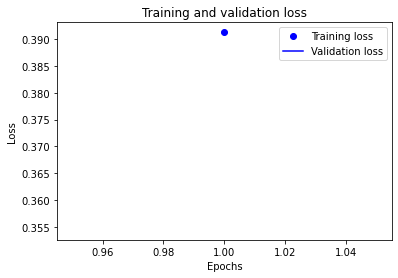

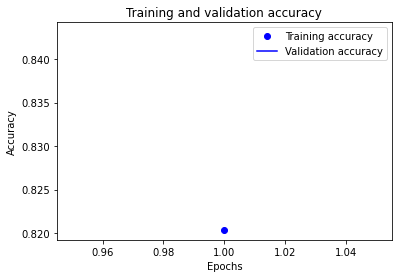

In [32]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [33]:
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/ko/word2vec_ko_LSTM.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.
#vocab_size

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model_LSTM.get_weights()[0]
for i in range(4,vocab_size): #vocab_size
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()


In [37]:
from gensim.models import KeyedVectors
import os
import gensim
word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
word_vectors.similar_by_word("사랑")

KeyError: "word '사랑' not in vocabulary"

# 사전학습 데이터 활용

In [36]:
from gensim.models import KeyedVectors
import os
import gensim

ko_model = gensim.models.Word2Vec.load('~/aiffel/ko/ko.bin')
word2vec = ko_model
word2vec.similar_by_word("사랑")

/home/aiffel/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  import sys


[('슬픔', 0.7216663360595703),
 ('행복', 0.6759077310562134),
 ('절망', 0.6468985676765442),
 ('기쁨', 0.6458414793014526),
 ('이별', 0.6334798336029053),
 ('추억', 0.6320937871932983),
 ('인생', 0.6216273307800293),
 ('애정', 0.6206068992614746),
 ('연인', 0.6186063289642334),
 ('유혹', 0.5965287685394287)]

# 정수 인코딩

In [ ]:
#tokenizer = Tokenizer()
#tokenizer.fit_on_texts(X_train)
print(X_train[:3])

In [ ]:
threshold = 3
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100

In [ ]:
# 전체 단어 개수 중 빈도수 2이하인 단어 개수는 제거.
# 0번 패딩 토큰과 1번 OOV 토큰을 고려하여 +2
vocab_size = total_cnt - rare_cnt + 2
print('단어 집합의 크기 :',vocab_size)
      
# 전체 단어 개수 중 빈도수 2이하인 단어 개수는 제거.
# 0번 패딩 토큰과 1번 OOV 토큰을 고려하여 +2
vocab_size = total_cnt - rare_cnt + 2
print('단어 집합의 크기 :',vocab_size)

In [ ]:
tokenizer = Tokenizer(vocab_size, oov_token = 'OOV') 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)
print(X_train[:3])

y_train = np.array(train_data['label'])
y_test = np.array(test_data['label'])

반적으로 자음의 범위는 ㄱ ~ ㅎ, 모음의 범위는 ㅏ ~ ㅣ와 같이 지정할 수 있습니다. 해당 범위 내에 어떤 자음과 모음이 속하는지 알고 싶다면 아래의 링크를 참고하시기 바랍니다.

https://www.unicode.org/charts/PDF/U3130.pdf
ㄱ ~ ㅎ: 3131 ~ 314E
ㅏ ~ ㅣ: 314F ~ 3163

또한 완성형 한글의 범위는 가 ~ 힣과 같이 사용합니다. 해당 범위 내에 포함된 음절들은 아래의 링크에서 확인할 수 있습니다.
https://www.unicode.org/charts/PDF/UAC00.pdf



# 토큰화

In [ ]:
from konlpy.tag import Mecab
tokenizer = Mecab()
okt = Okt()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

In [ ]:
#데이터 중복 제거
X_train = []
for sentence in train_data['document']:
    temp_X = []
    temp_X = okt.morphs(sentence, stem=True) # 토큰화
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
    X_train.append(temp_X)

X_test = []
for sentence in test_data['document']:
    temp_X = []
    temp_X = okt.morphs(sentence, stem=True) # 토큰화
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
    X_test.append(temp_X)    
print(X_train[:3])

# 정수 인코딩


In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [ ]:
threshold = 3
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

In [ ]:
# 전체 단어 개수 중 빈도수 2이하인 단어 개수는 제거.
# 0번 패딩 토큰과 1번 OOV 토큰을 고려하여 +2
vocab_size = total_cnt - rare_cnt + 2
print('단어 집합의 크기 :',vocab_size)

In [ ]:
# 전체 단어 개수 중 빈도수 2이하인 단어 개수는 제거.
# 0번 패딩 토큰과 1번 OOV 토큰을 고려하여 +2
vocab_size = total_cnt - rare_cnt + 2
print('단어 집합의 크기 :',vocab_size)

tokenizer = Tokenizer(vocab_size, oov_token = 'OOV') 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)
print(X_train[:3])

y_train = np.array(train_data['label'])
y_test = np.array(test_data['label'])

In [ ]:
print(X_train[:3])

In [ ]:
y_train = np.array(train_data['label'])
y_test = np.array(test_data['label'])

# 빈샘플 제거

In [ ]:
drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]

In [ ]:
# 빈 샘플들을 제거
X_train = np.delete(X_train, drop_train, axis=0)
y_train = np.delete(y_train, drop_train, axis=0)

print(len(X_train))
print(len(y_train))

In [ ]:
words = np.concatenate(X_train).tolist()
counter = Counter(words)
counter = counter.most_common(10000-4)    
vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
word_to_index = {word:index for index, word in enumerate(vocab)} # enumerate 열거하다
    
def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]

X_train = list(map(wordlist_to_indexlist, X_train))
X_test = list(map(wordlist_to_indexlist, X_test))

index_to_word = {index:word for word, index in word_to_index.items()}

In [ ]:
# 아래 다른 모델 테스트용으로 데이터 가공이 달라질 수 있어서 미리 복사를 해두자

X_train_2 = X_train
X_test_2 = X_test
y_train_2 = y_train
y_test_2 = y_test

X_train_3 = X_train
X_test_3 = X_test
y_train_3 = y_train
y_test_3 = y_test

# 패딩

In [ ]:
print('리뷰의 최대 길이 :',max(len(l) for l in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [ ]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))*100))

In [ ]:
max_len = 30
below_threshold_len(max_len, X_train)


In [ ]:
# 30을 기준으로 패딩을 함. padding은 post보다 pre가 10% 가량 성능향상이 있으므로 pre로 설정

In [ ]:
X_train = pad_sequences(X_train, padding='pre', maxlen = max_len)
X_test = pad_sequences(X_test, padding='pre', maxlen = max_len)


# LSTM으로 분류하기

In [ ]:
model_LSTM = Sequential()
model_LSTM.add(Embedding(vocab_size, 200))
model_LSTM.add(LSTM(128))
model_LSTM.add(Dense(1, activation='sigmoid'))
model_LSTM.summary()

In [ ]:
#es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
#mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [ ]:
epochs=10

model_LSTM.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
history = model_LSTM.fit(X_train, y_train, epochs=epochs, batch_size=60, validation_split=0.2)

In [ ]:
results = model_LSTM.evaluate(X_test,  y_test, verbose=2)
print(results)

In [ ]:
#oaded_model = load_model('best_model.h5')
#print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

In [ ]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [ ]:
embedding_layer_LSTM = model_LSTM.layers[0]
weights = embedding_layer_LSTM.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)


In [ ]:
word_vector_dim = 200  # 단어 하나를 표현하는 임베딩 벡터의 차원수입니다. 
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다.
word2vec_file_path_LSTM = os.getenv('HOME')+'/aiffel/ko/kor_w2v.txt'
f = open(word2vec_file_path_LSTM, 'w')
f.write('{} {}\n'.format(10000-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

In [ ]:
# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors_LSTM = model_LSTM.get_weights()[0]

In [ ]:
for i in range(4,10000):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors_LSTM[i, :])))))
f.close()

In [ ]:
word_vectors_LSTM = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path_LSTM, binary=False)
word_vectors_LSTM.similar_by_word("사랑")


In [ ]:
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)
for i in range(4,10000):
    if index_to_word[i] in word_vectors_LSTM:
        embedding_matrix[i] = word_vectors_LSTM[index_to_word[i]]

In [ ]:
from tensorflow.keras.initializers import Constant

model_LSTM = Sequential()
model_LSTM.add(keras.layers.Embedding(10000, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=max_len, 
                                 trainable=False))   # trainable을 True로 주면 Fine-tuningmodel_LSTM.add(LSTM(128))
model_LSTM.add(Dense(1, activation='sigmoid'))
model_LSTM.summary()

# RNN 분류기

In [ ]:
#vocab_size = 100  # 어휘 사전의 크기입니다(10개의 단어), 위에서 사이즈가 정해져 있으므로 생략

word_vector_dim = 100  # 단어 하나를 표현하는 임베딩 벡터의 차원수입니다. 

# 모델은 위와 구조는 동일하나 노드에서 나온 모델로 다시 테스트를 해보자. 
model = keras.Sequential()

model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.LSTM(8))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경가능)
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()


In [ ]:
print(len(X_train_2))
print(len(y_train_2))

In [ ]:
# 보통 20프로 정도 validation데이터로 사용하므로 3만건 정도 생각함!
# validation set 30000건 분리

x_val = X_train_2[:30000]   
y_val = y_train_2[:30000]

In [ ]:
# validation set을 제외한 나머지 115380건
partial_x_train = X_train_2[30000:]  
partial_y_train = y_train_2[30000:]

In [ ]:
print(partial_x_train.shape)
print(partial_y_train.shape)

In [ ]:
max_len = 30
below_threshold_len(max_len, X_train_2)

#partial_x_train = pad_sequences(partial_x_train, maxlen = max_len)
partial_x_train = pad_sequences(partial_x_train, maxlen = max_len)
X_test_2 = pad_sequences(X_test_2, maxlen = max_len)
x_val = pad_sequences(x_val, maxlen = max_len)
#y_val = pad_sequences(y_val, maxlen = max_len)

In [ ]:

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=256,
                    validation_data=(x_val, y_val))

In [ ]:
results = model.evaluate(X_test_2,  y_test_2, verbose=2)
print(results)

In [ ]:
print("\n 테스트 정확도: %.4f" % (model.evaluate(X_test_2, y_test_2)[1]))


In [ ]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# CNN 분류기

In [ ]:
x_val = X_train_3[:30000]   
y_val = y_train_3[:30000]
partial_x_train = X_train_3[30000:]  
partial_y_train = y_train_3[30000:]
max_len = 30
below_threshold_len(max_len, X_train_3)

#partial_x_train = pad_sequences(partial_x_train, maxlen = max_len)
partial_x_train = pad_sequences(partial_x_train, maxlen = max_len)
X_test_3 = pad_sequences(X_test_3, maxlen = max_len)
x_val = pad_sequences(x_val, maxlen = max_len)
#y_val = pad_sequences(y_val, maxlen = max_len)

In [ ]:
word_vector_dim = 16   # 단어 하나를 표현하는 임베딩 벡터의 차원수입니다. 

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.MaxPooling1D(5))
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

In [ ]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val), 
                    verbose=1)

In [ ]:
results = model.evaluate(X_test_3,  y_test_3, verbose=2)
print(results)

In [ ]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# Maxpooling 분류기

In [ ]:
#vocab_size = 10  # 어휘 사전의 크기입니다(10개의 단어)
word_vector_dim = 4   # 단어 하나를 표현하는 임베딩 벡터의 차원수입니다. 

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

In [ ]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val), 
                    verbose=1)

In [ ]:
results = model.evaluate(X_test_3,  y_test_3, verbose=2)
print(results)

In [ ]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# 2. gensim, Word2Vec 불러오기

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import urllib.request
import gensim
from konlpy.tag import Okt
import os

In [ ]:
ko_model = gensim.models.Word2Vec.load('~/aiffel/ko/ko.bin')
a = ko_model.wv.most_similar("사랑")
print(a)

# 3. Word2Vec 만들기

In [ ]:
train_data = pd.read_table('~/aiffel/ko/ratings.txt')

In [ ]:
train_data[:5] 

In [ ]:
print(len(train_data))

In [ ]:
# NULL 값 존재 유무
print(train_data.isnull().values.any())

In [ ]:
train_data = train_data.dropna(how = 'any') # Null 값이 존재하는 행 제거
print(train_data.isnull().values.any()) # Null 값이 존재하는지 확인

In [ ]:
print(len(train_data)) # 리뷰 개수 출력

In [ ]:
# 정규 표현식을 통한 한글 외 문자 제거
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")

In [ ]:
train_data[:5] # 상위 5개 출력

In [ ]:
# 불용어 정의
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

In [ ]:
# 형태소 분석기 OKT를 사용한 토큰화 작업 (다소 시간 소요)
okt = Okt()
tokenized_data = []
for sentence in train_data['document']:
    temp_X = okt.morphs(sentence, stem=True) # 토큰화
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
    tokenized_data.append(temp_X)

In [ ]:
# 리뷰 길이 분포 확인
print('리뷰의 최대 길이 :',max(len(l) for l in tokenized_data))
print('리뷰의 평균 길이 :',sum(map(len, tokenized_data))/len(tokenized_data))
plt.hist([len(s) for s in tokenized_data], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [ ]:
from gensim.models import Word2Vec

model = Word2Vec(sentences = tokenized_data, size = 100, window = 5, min_count = 5, workers = 4, sg = 0)

In [ ]:
# 완성된 임베딩 매트릭스의 크기 확인
model.wv.vectors.shape

In [ ]:
print(model.wv.most_similar("사랑"))


In [ ]:
from gensim.models import KeyedVectors
model.wv.save_word2vec_format('kor_w2v') # 모델 저장
loaded_model 
= KeyedVectors.load_word2vec_format("kor_w2v") # 모델 로드


In [ ]:
model_result = loaded_model.most_similar("사랑")
print(model_result)

# 학습된 word2vec 로 모델 학습하기

In [ ]:
#vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

# model 설계 - 딥러닝 모델 코드를 직접 작성해 주세요.
model = keras.Sequential()

model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.MaxPooling1D(5))
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

In [ ]:
#vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 300  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

In [ ]:
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/ko/kor_w2v.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.


word_to_index = imdb.get_word_index()
index_to_word = {index:word for word, index in word_to_index.items()}
print(index_to_word[1])     # 'the' 가 출력됩니다. 
print(word_to_index['the'])  # 1 이 출력됩니다.

In [ ]:

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [ ]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['사랑']
vector

In [ ]:


embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in ko_model:
        embedding_matrix[i] = ko_model[index_to_word[i]]
from tensorflow.keras.initializers import Constant

# 모델 구성
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.MaxPooling1D(5))
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid')) 

model.summary()
# 학습의 진행
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)
# 테스트셋을 통한 모델 평가
results = model.evaluate(x_test,  y_test, verbose=2)

# 4. 결론


자연어 처리에서 RNN, CNN, Maxpooling 모델을 통해서 결과를 확인해보았다.
결과는 예상대로 RNN이 가장 높은 성능을 보여주었고 CNN의 경우는 다소 학습이 안되는 결과로 보여졌다.
  LSTM 1 - loss: 0.3451 - acc: 0.8549
  LSTM 2 - loss: 0.8651 - acc: 0.8183
  CNN - loss: 0.8807 - acc: 0.5724
  Maxpooling - loss: 0.4654 - acc: 0.8101
LSTM은 Long Short-Term Memory는 RNN에서 forget gate를 추가한것으로 RNN의 일종으로 모델을 구성하였다.
자연어처리에서 전단계의 과거 학습 데이터를 재귀 시키는 형태로서, 이전의 값을 메모리 형태로 기억되어 순차적인 데이터열 처리에 적합함을 확인할 수 있었다.
CNN에서 1-D conv층으로 RNN과 같이 자연어 처리를 할 수 있지만 이전 데이터가 중요한 자연어처리에서 다소 모델이 안좋게 나온것을 확인할 수 있었다. 노드에서 추천해준대로 RNN, CNN을 결합하여 하이브리드 형태로 구성을 하면 더 좋은 성능의 모델을 구성할 수 있을것으로 예상을 한다. 